In [1]:
import numpy as np
import xarray as xr
import pandas as pd

In [2]:
era5 = xr.open_dataset('/Users/doan/Downloads/same_with_NAROdata_domain (1).nc')['t2m']

In [3]:
de = era5.groupby('valid_time.date').mean() - 273.15

In [4]:
ds = xr.open_dataset('/Users/doan/Downloads/NARO_data2023 (1).nc')['TMP_mea']

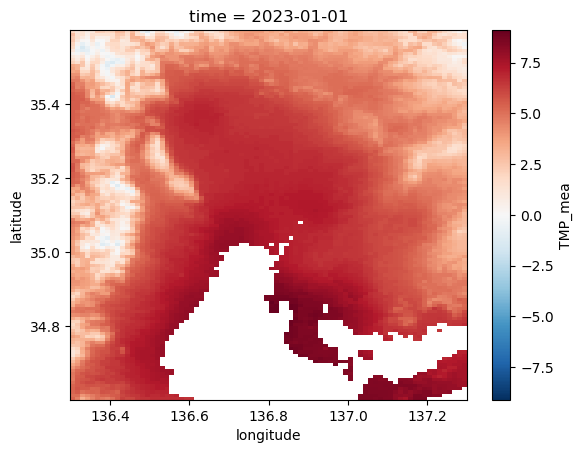

In [5]:
dna = ds.sel(latitude=slice(34.6, 35.6), longitude=slice(136.3, 137.3))
dna[0].plot()

<xarray.DataArray 'TMP_mea' (time: 365, latitude: 120, longitude: 104)> Size: 36MB
[4555200 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 3kB 2023-01-01 2023-01-02 ... 2023-12-31
  * latitude   (latitude) float32 480B 34.6 34.61 34.62 ... 35.58 35.59 35.6
  * longitude  (longitude) float32 416B 136.0 136.0 136.0 ... 137.3 137.3 137.3


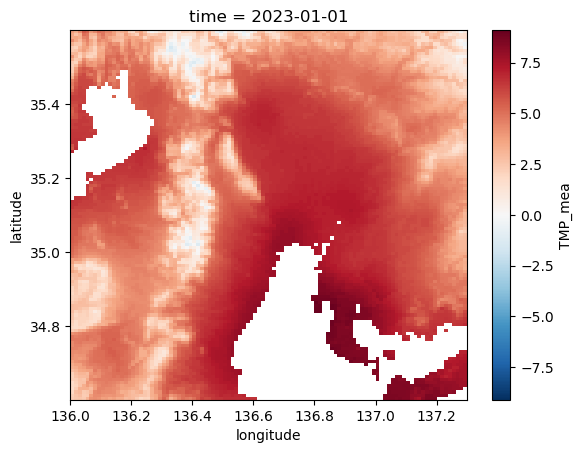

In [6]:
latslide = (35, 35.2)
lonslide  = (136.55, 136.95)
latslide = (34.6, 35.6)
lonslide = (136, 137.3)
dna = ds.sel(latitude=slice(latslide[0], latslide[1]), longitude=slice(lonslide[0], lonslide[1]))
print(dna)
dna[0].plot()

In [7]:
dex = de.sel(latitude=slice(latslide[1], latslide[0]), longitude=slice(lonslide[0], lonslide[1]))

In [8]:
dex[0]

<xarray.DataArray 't2m' (latitude: 4, longitude: 6)> Size: 96B
array([[7.3009033, 5.4968567, 5.10437  , 5.533386 , 6.144562 , 4.300476 ],
       [6.1656494, 6.0768433, 6.469757 , 6.7676086, 6.911804 , 5.3799133],
       [5.158722 , 5.8474426, 7.0281067, 7.9833374, 8.229034 , 6.555786 ],
       [5.833191 , 5.8720093, 6.969116 , 8.213165 , 8.976349 , 8.57547  ]],
      dtype=float32)
Coordinates:
    number     int64 8B ...
  * latitude   (latitude) float64 32B 35.5 35.25 35.0 34.75
  * longitude  (longitude) float64 48B 136.0 136.2 136.5 136.8 137.0 137.2
    date       object 8B 2023-01-01

In [9]:
# Load the low and high-resolution datasets
lo_ds = de
hi_ds = dna
# Perform the interpolation to match the high-resolution coordinates
# Assuming 'latitude' and 'longitude' as the coordinate names in both datasets
lo_regridded = lo_ds.interp(latitude=hi_ds.latitude, longitude=hi_ds.longitude, method="nearest")



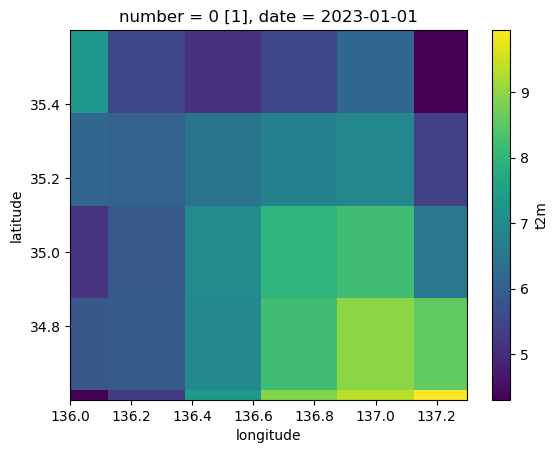

In [10]:
lo_regridded[0].plot()

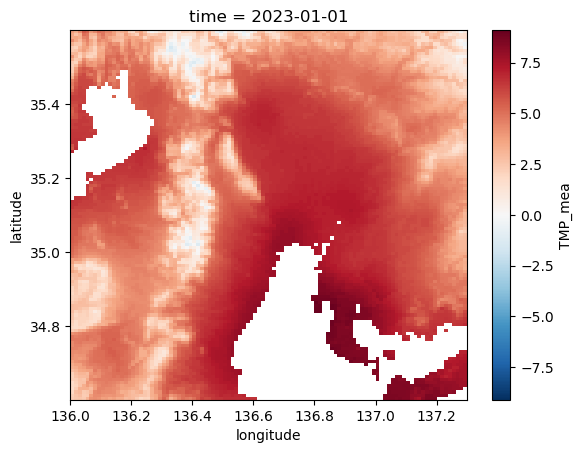

In [11]:
hi_ds[0].plot()

## Make low- and high-res data and put is together

this is just reference code, one can do it flexibly


 

In [12]:
do = xr.Dataset( {'hi': ( ('date', 'latitude', 'longitude'), hi_ds.values), 
                  'lo': (('date', 'latitude', 'longitude'), lo_regridded.values) } )

In [13]:
do.coords['date'] = ('date', hi_ds.time.values) 
do.coords['latitude'] = ('latitude', hi_ds.latitude.values) 
do.coords['longitude'] = ('longitude', hi_ds.longitude.values) 

In [14]:
do['mask'] = (("latitude", "longitude"), do.hi.isel(date=0).isnull().values)

In [15]:
do['hi'] = do.hi.fillna(do.lo)


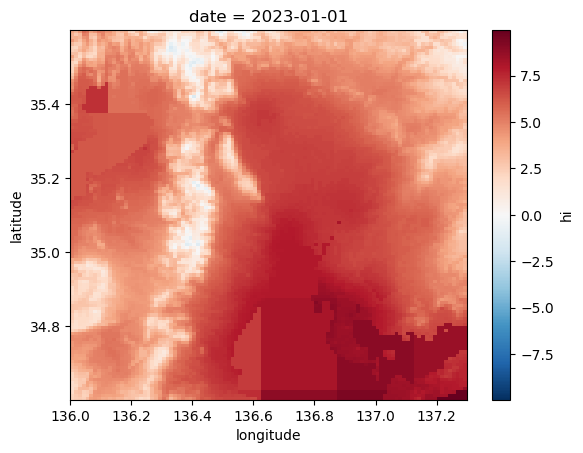

In [16]:
do['hi'][0].plot()

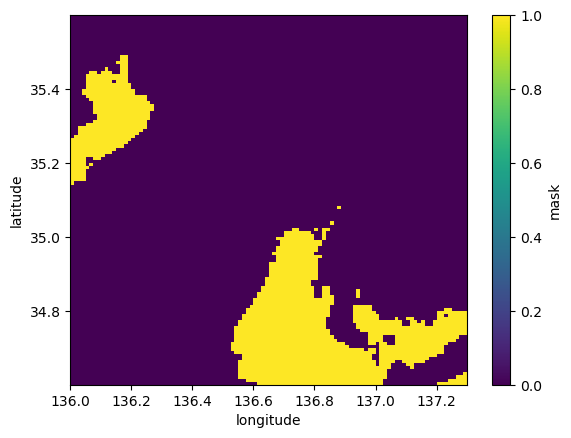

In [17]:
do['mask'].plot()

In [18]:
do.to_netcdf('data/nagoya_input.nc')

## Divide data into three sets
- training
- validating
- testing

Here random selection is used.

70% of data is used for training

60% of remaining 30% is used for validation

40% of remaining 30% is used for testing

__there is no any rules how to divide, this is just a showcase__

__data is then writen into three seperate files__


### techniques used

> random
> 
> numpy .setdiff1d
>
> numpy .unique
>
> numpy .union1d
>
> xarray .isel (different with .sel)

In [19]:
do.close()

In [20]:
dinput = xr.open_dataset('data/nagoya_input.nc')

we have  365 sample


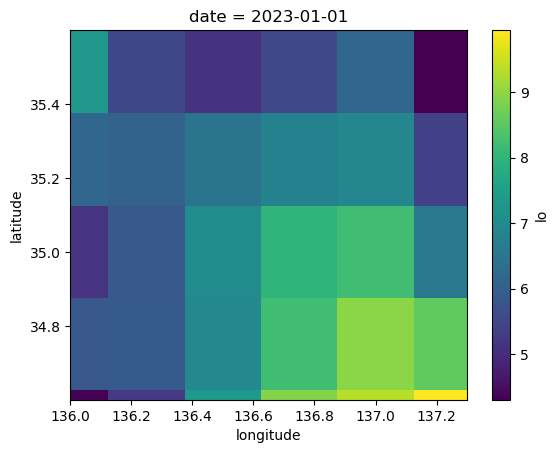

In [21]:
dinput.lo[0].plot()
#n = 365
n = dinput['hi'].shape[0]
print('we have ', n, 'sample')

In [22]:
# separate data to three part: 1) training; 2) validation; 3) test
ii = np.arange(n)
n_train = int(round(.7*n))
print('extract: ', n_train, 'for training')

extract:  255 for training


In [23]:
import random
itrain=[]
while len(itrain) !=  n_train :
   r=random.randint(0,n-1)
   if r not in itrain: itrain.append(r)

In [24]:
print( 'check len of training data: ', len(np.unique(itrain)), len(itrain))
print('get 70% of whole data to train: ', len(itrain))

check len of training data:  255 255
get 70% of whole data to train:  255


In [25]:
i2 = np.setdiff1d(ii, itrain)
print('then we have remaining ', len(i2))

then we have remaining  110


In [26]:
n_vt = len(i2)
n_val = int(round(.6*n_vt))

In [27]:
j1=[]
while len(j1) !=  n_val :
    r=random.randint(0, n_vt - 1)
    if r not in j1: j1.append(r)

In [28]:
ival = i2[j1]
itest = np.setdiff1d(i2, ival)

In [29]:
print(np.unique(np.union1d(itrain, np.union1d(ival, itest))).shape)
print(len(itrain) + len(ival) + len(itest))
# -

(365,)
365


In [31]:
dtrain0 = dinput.isel(date=itrain)
dval0 = dinput.isel(date=ival)
dtest0 = dinput.isel(date=itest)


# =====
dtrain0.to_netcdf('data/nagoya_train.nc')
dval0.to_netcdf('data/nagoya_val.nc')
dtest0.to_netcdf('data/nagoya_test.nc')

